In [7]:
!python3 minesweeper_playable_v2.py

Traceback (most recent call last):
  File "/home/tilman/Documents/repositories/OMfE/minesweeper_playable_v2.py", line 33, in <module>
    demo_board = np.array(pd.read_csv('minesweeper_demo_board.csv'))
  File "/home/tilman/miniconda3/envs/omfe/lib/python3.10/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/tilman/miniconda3/envs/omfe/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 680, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/tilman/miniconda3/envs/omfe/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 575, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/tilman/miniconda3/envs/omfe/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 934, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/home/tilman/miniconda3/envs/omfe/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1218, in _make_

In [2]:
%load_ext autoreload
%autoreload 2

from graphics import (
    GraphWin,
    Point,
    Line,
    Text,
    Rectangle,
    color_rgb,

    GraphicsError
)
import numpy as np
import matplotlib.pyplot as plt
import sys

def progress(count, total, status=''):
    bar_len = 50
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '█' * filled_len + ' ' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [11]:
pheromone_graph = np.array([[1,2],[3,4],[5,6]])
print(1/3, 3/7, 5/11)
pheromone_graph[:, 0] / pheromone_graph.sum(axis=1)

0.3333333333333333 0.42857142857142855 0.45454545454545453


array([0.33333333, 0.42857143, 0.45454545])

In [21]:
outputs = [(4, 3, 0, 4), (6, 1, 0, 1), (0, 2, 1, 2), (0, 2, 1, 2), (5, 4, 1, 2), (2, 1, 3, 2), (6, 5, 1, 2), (5, 0, 0, 2), (0, 3, 2, 1), (2, 2, 0, 2), (3, 3, 0, 1), (4, 3, 0, 1), (6, 2, 1, 2), (5, 2, 0, 1), (6, 1, 1, 1), (0, 4, 1, 2), (5, 3, 0, 3), (0, 0, 0, 2), (4, 3, 1, 1), (4, 1, 1, 2)]

In [19]:
np.mean([1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 1, 0])

0.8

In [23]:
np.array(outputs).mean(axis=0)

array([3.35, 2.25, 0.7 , 1.8 ])

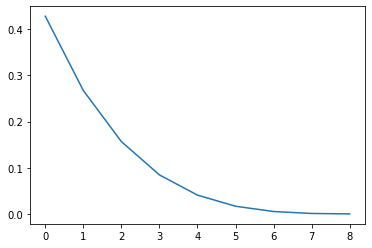

In [9]:
solutions = np.array([1,2,3,4,5,6,7,8,9])
rank_probabilities = np.arange(len(solutions) - 1, 0, -1) ** 4
probability = rank_probabilities / np.sum(rank_probabilities)

chosen_survivors = np.random.choice(
    10, p=probability, size=5-1, replace=False)

solutions[chosen_survivors]

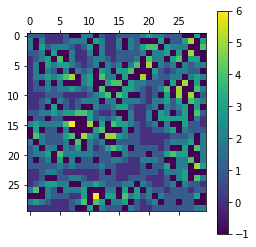

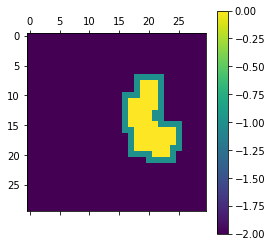

(array([14]), array([18]))


In [20]:
board_size = 30, 30
n_mines = 200
neighbors_tuple = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]



# Generate a random field of mines
mines = np.zeros(board_size)
positions = np.random.choice(
    board_size[0] * board_size[1], size=n_mines, replace=False)
positions = np.unravel_index(positions, board_size)
mines[positions] = 1



# Generate mine neighbors
padded_mines = np.zeros((board_size[0]+2, board_size[1]+2))
padded_mines[1:-1, 1:-1] = mines

neighbors = []
for i, j in neighbors_tuple:
    i, j = i + 1, j + 1
    shifted_mines = padded_mines[i:board_size[0]+i, j:board_size[1]+j]
    neighbors.append(shifted_mines)
neighbors = np.stack(neighbors, axis=-1)

minesweeper = np.sum(neighbors, axis=-1, dtype=int)
minesweeper[mines == 1] = -1

plt.matshow(minesweeper)
plt.colorbar()
plt.show()



# Find initial start squares
if (minesweeper != 0).all():
    # This should never (but can) happen
    raise ValueError("Minesweeper contains no zero square, restart")
potential_starts = np.where(minesweeper == 0)
chosen_option = np.random.choice(potential_starts[0].size, size=1)
start = (potential_starts[0][chosen_option],
         potential_starts[1][chosen_option])
tmp = minesweeper.copy()
tmp[start] = 9



# Generate visible field
# -2 = unexplored, -1 = explored, 0 = empty, 1 = mine
visible_tiles = np.full_like(minesweeper, -2)

def uncover_square(x, y):
    visible_tiles[x, y] = 0
    if minesweeper[x, y] == -1:
        visible_tiles[x, y] = 1
    elif minesweeper[x, y] == 0:
        for i, j in neighbors_tuple:
            if 0 <= x + i < board_size[0] and 0 <= y + j < board_size[1] and visible_tiles[x+i, y+j] < 0:
                uncover_square(x+i, y+j)
    else:
        for i, j in neighbors_tuple:
            if 0 <= x + i < board_size[0] and 0 <= y + j < board_size[1] and visible_tiles[x+i, y+j] == -2:
                visible_tiles[x+i, y+j] = -1

[uncover_square(x, y) for x, y in zip(*start)]

plt.matshow(visible_tiles)
plt.colorbar()
plt.show()



# Solution checker
def satisfies_sweeper(solution, visible_tiles=visible_tiles):
    errors = 0
    for i, j in np.ndindex(visible_tiles.shape):
        if visible_tiles[i, j] == 0:
            neighbors = solution[max(0, i-1):min(board_size[0], i+2), max(0, j-1):min(board_size[1], j+2)]
            neighbors[neighbors == -2] = 0
            number_of_bombs = np.sum(neighbors)
            if number_of_bombs != minesweeper[i, j]:
                errors += np.abs(number_of_bombs - minesweeper[i, j])
    return errors



# Fitness function
def fitness(solution, visible_tiles=visible_tiles):
    solution_full = visible_tiles.copy()
    solution_full[visible_tiles == -1] = solution
    solution = solution_full
    return satisfies_sweeper(solution, visible_tiles)

import pandas as pd
pd.DataFrame(minesweeper).to_csv('minesweeper_demo_board.csv', header=False, index=False)
print(start)


In [ ]:
# Solve obvious squares
def solve_obvious(game_tiles):
    flagged_tiles = game_tiles.copy()
    for x, y in np.ndindex(flagged_tiles.shape):
        if flagged_tiles[x, y] == 0:
            number_of_bombs = minesweeper[x, y]

            neighbors = flagged_tiles[max(0, x-1):min(board_size[0], x+2), max(0, y-1):min(board_size[1], y+2)]
            number_of_covered_tiles = np.sum(neighbors != 0).astype(int)

            if number_of_bombs == number_of_covered_tiles:
                for i, j in neighbors_tuple:
                    if 0 <= x + i < board_size[0] and 0 <= y + j < board_size[1] and flagged_tiles[x+i, y+j] < 0:
                        flagged_tiles[x+i, y+j] = 1
    return flagged_tiles



# Find wrongly predicted tiles
def solve_error_tiles(game_tiles, solution):
    error_tiles = np.zeros_like(solution)
    for i, j in np.ndindex(solution.shape):
        if game_tiles[i, j] == 0:
            neighbors = solution[max(0, i-1):min(board_size[0], i+2), max(0, j-1):min(board_size[1], j+2)]
            number_of_bombs = np.sum((neighbors == 1).astype(int))
            if number_of_bombs != minesweeper[i, j]:
                error_tiles[i, j] = 1
    return error_tiles


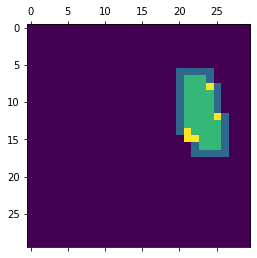

In [ ]:
square_size = 50
font_size = 10

win = GraphWin("Minesweeper", board_size[0]*square_size, board_size[1]*square_size)
try:
    tmp = solve_obvious(visible_tiles)
    plt.matshow(tmp)
    show_minesweeper(win, minesweeper, tmp, square_size=square_size, font_size=font_size)
    win.getMouse()
except GraphicsError:
    pass
finally:
    win.close()

[██████████████████████████████████████████████████] 100.0% ...	Iteration: 299	Error: 3	Solution not found


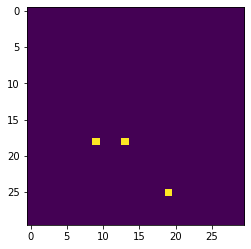

In [ ]:
from functools import partial
from GeneticAlgorithm import ga_solver
from microGeneticAlgorithm import micro_ga_solver
from display_minesweeper import initialize_minesweeper, update_minesweeper

parameters = {
    "n_generations": 300,
    "n_individuals": 100,
    "n_survivors": 30,
    "n_crossovers": 10,
    "n_mutations": 5,
}

square_size = 50
font_size = 10

game_tiles = visible_tiles.copy()
ga_solution_full = np.zeros_like(game_tiles)
error_tiles = np.zeros_like(game_tiles)

win = initialize_minesweeper(minesweeper, square_size=square_size, font_size=font_size)
try:
    update_minesweeper(win, game_tiles)

    def handle_click(case, x, y):
        game_tiles[x, y] = 0
        if case == 0:
            for i, j in neighbors_tuple:
                if 0 <= x + i < board_size[0] and 0 <= y + j < board_size[1] and game_tiles[x+i, y+j] < 0:
                    handle_click(minesweeper[x+i, y+j], x+i, y+j)
        elif case > 0:
            for i, j in neighbors_tuple:
                if 0 <= x + i < board_size[0] and 0 <= y + j < board_size[1] and game_tiles[x+i, y+j] == -2:
                    game_tiles[x+i, y+j] = -1

    while(win.isOpen()):
        point, is_right_click = win.getMouse()
        x, y = point.getX(), point.getY()
        x = int(x/square_size)
        y = int(y/square_size)

        if y >= board_size[1]:
            game_tiles = solve_obvious(game_tiles)
            update_minesweeper(win, game_tiles)

            solution_tiles = game_tiles == -1
            solution_space = np.sum(solution_tiles.astype(int))

            ga_solution, error = ga_solver(solution_space, partial(fitness, visible_tiles=game_tiles), **parameters)
            ga_solution_full = game_tiles.copy()
            ga_solution_full[solution_tiles] = ga_solution

            error_tiles = solve_error_tiles(game_tiles, ga_solution_full)

            update_minesweeper(win, game_tiles, ga_solution=ga_solution_full, error_tiles=error_tiles)
            continue

        if game_tiles[x, y] == 0:
            continue

        if is_right_click:
            if game_tiles[x, y] == -1:
                game_tiles[x, y] = 1
            elif game_tiles[x, y] == 1:
                game_tiles[x, y] = -1
            update_minesweeper(win, game_tiles, ga_solution=ga_solution_full, error_tiles=error_tiles)
            continue

        case = minesweeper[x, y]
        handle_click(case, x, y)

        update_minesweeper(win, game_tiles, ga_solution=ga_solution_full, error_tiles=error_tiles)

        if case == -1:
            win.getMouse()
            win.close()
            break

except GraphicsError:
    pass
finally:
    win.close()

In [ ]:
def test(a=None, b=None):
    print(a, b)

args = {
    'a':"Hello",
    'b':"World"
}

test(**args)

Hello World


Solution space: 16
[██████                                            ] 11.0% ...	Iteration: 10	Error: 0	Finished
GA error: 0
GA time: 1.3399014472961426 seconds
[███████                                           ] 13.8% ...	Iteration: 1	SubIteration: 37	Error: 0	Finished	
MicroGA error: 0
MicroGA time: 1.4930429458618164 seconds


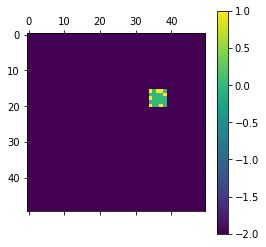

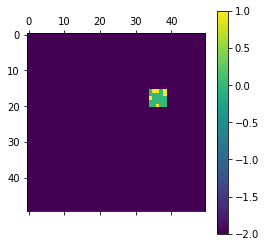

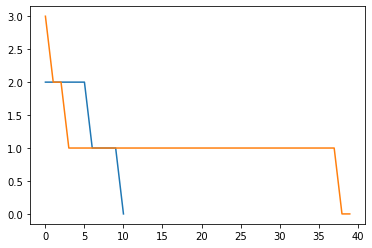

In [ ]:
from GeneticAlgorithm import ga_solver
from microGeneticAlgorithm import micro_ga_solver
import time

solution_evo = solve_obvious(visible_tiles)
solution_tiles = solution_evo == -1
solution_space = np.sum(solution_tiles.astype(int))
print("Solution space: {}".format(solution_space))

initial_solution = np.random.choice(2, size=solution_space, p=[0.5, 0.5])

tik = time.time()
ga_solution, error = ga_solver(solution_space, fitness,
                               initial_solution=initial_solution)
tok = time.time()
print("GA error: {}".format(error[-1]))
print("GA time: {} seconds".format(tok - tik))

tik = time.time()
micro_ga_solution, m_error = micro_ga_solver(solution_space, fitness, initial_solution=initial_solution,
                                             n_generations=10, n_sub_generations=100,
                                             n_individuals=31, n_crossovers=10)
tok = time.time()
print("MicroGA error: {}".format(m_error[-1]))
print("MicroGA time: {} seconds".format(tok - tik))

solution_evo[solution_tiles] = ga_solution
plt.matshow(solution_evo)
plt.colorbar()
plt.show()

solution_evo[solution_tiles] = micro_ga_solution
plt.matshow(solution_evo)
plt.colorbar()
plt.show()

plt.plot(error)
plt.plot(m_error)
plt.show()


In [ ]:
import numpy as np
tmp = np.array([[1,2,3],[4,5,6],[7,8,9]])
len(tmp)

3

In [ ]:
solution_evo = visible_tiles.copy()
solution_space = solution_evo[solution_evo == -1].size
print("Solution space: {}".format(solution_space))

possible_parameters = {
    "n_survivors": [15, 30, 50, 75],
    "n_mutations": [5, 10, 15, 20, 30, 50, 75, 100, 125, 150],
    "n_crossover": [5, 10, 15, 30, 75]
}
shape = tuple([len(possible_parameters[k]) for k in possible_parameters.keys()])

n_generations = 50
n_individuals = 100
generated_solutions = np.random.randint(0, 2, size=(n_individuals, solution_space))
for surv, mut, cross in np.ndindex(shape):
    n_survivors = possible_parameters["n_survivors"][surv]
    n_mutations = possible_parameters["n_mutations"][mut]
    n_crossovers = possible_parameters["n_crossover"][cross]

    print(f"Testing parameters: n_generations={n_generations}, \
        n_individuals={n_individuals}, \
        n_survivors={n_survivors}, \
        n_mutations={n_mutations}, \
        n_crossovers={n_crossovers}")
    solution, error = ga_solver(solution_space,
        generated_solutions=generated_solutions,
        n_generations=n_generations,
        n_individuals=n_individuals,
        n_survivors=n_survivors,
        n_mutations=n_mutations,
        n_crossovers=n_crossovers)




plt.matshow(solution_evo)
plt.colorbar()
plt.show()

plt.plot(error)
plt.show()

In [ ]:
output = """Solution space: 415
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=5, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 136	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=5, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 143	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=5, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 121	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=5, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 140	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=5, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=10, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 141	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=10, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=10, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 145	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=10, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 141	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=10, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=15, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 146	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=15, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 147	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=15, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 147	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=15, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=15, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=20, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=20, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=20, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=20, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 151	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=20, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=30, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=30, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=30, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=30, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=30, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=50, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=50, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=50, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=50, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=50, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 149	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=75, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=75, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=75, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=75, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 158	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=75, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=100, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=100, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 151	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=100, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=100, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=100, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 159	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=125, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 151	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=125, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=125, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=125, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=125, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=150, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 160	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=150, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 159	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=150, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 159	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=150, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=15, n_mutations=150, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 163	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=5, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 125	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=5, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 120	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=5, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 124	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=5, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 124	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=5, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 132	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=10, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 136	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=10, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 139	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=10, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 144	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=10, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 141	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=10, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 139	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=15, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 136	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=15, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 142	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=15, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 137	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=15, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 151	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=15, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=20, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 145	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=20, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 146	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=20, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 147	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=20, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 145	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=20, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=30, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=30, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 145	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=30, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 151	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=30, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=30, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=50, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=50, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=50, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=50, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=50, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=75, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=75, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 145	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=75, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 160	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=75, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=75, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=100, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=100, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=100, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=100, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=100, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=125, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=125, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=125, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=125, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=125, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 160	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=150, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=150, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=150, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 157	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=150, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=30, n_mutations=150, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=5, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 129	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=5, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 127	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=5, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 125	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=5, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 130	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=5, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 135	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=10, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 129	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=10, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 127	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=10, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 132	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=10, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 134	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=10, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 136	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=15, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 136	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=15, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 137	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=15, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 138	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=15, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 138	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=15, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 142	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=20, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 139	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=20, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 141	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=20, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 147	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=20, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 139	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=20, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 144	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=30, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 144	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=30, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 140	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=30, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 146	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=30, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 143	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=30, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=50, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=50, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=50, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=50, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 147	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=50, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=75, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=75, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 149	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=75, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=75, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 145	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=75, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=100, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=100, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=100, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=100, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=100, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=125, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=125, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=125, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 160	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=125, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=125, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=150, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 155	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=150, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 149	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=150, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 163	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=150, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 162	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=50, n_mutations=150, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 160	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=5, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 122	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=5, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 128	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=5, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 134	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=5, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 136	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=5, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 138	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=10, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 131	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=10, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 134	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=10, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 136	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=10, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 137	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=10, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 140	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=15, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 133	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=15, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 134	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=15, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 140	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=15, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 138	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=15, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 142	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=20, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 130	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=20, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 145	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=20, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 142	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=20, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 141	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=20, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=30, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 141	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=30, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=30, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 143	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=30, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 150	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=30, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 147	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=50, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 146	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=50, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 151	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=50, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 146	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=50, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 147	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=50, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 152	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=75, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=75, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 148	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=75, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=75, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 159	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=75, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 154	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=100, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 159	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=100, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 159	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=100, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 151	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=100, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 158	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=100, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 161	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=125, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=125, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 156	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=125, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 159	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=125, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 158	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=125, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 158	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=150, n_crossovers=5
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 161	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=150, n_crossovers=10
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 158	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=150, n_crossovers=15
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 153	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=150, n_crossovers=30
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 160	Solution not found
Testing parameters: n_generations=50, n_individuals=100, n_survivors=75, n_mutations=150, n_crossovers=75
[██████████████████████████████████████████████████] 100.0% ...	Iteration: 49	Error: 160	Solution not found
"""

In [ ]:
np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])[:, 2]

array([3, 6, 9])

['n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5', 'n_crossovers=5']


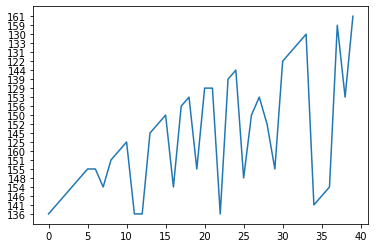

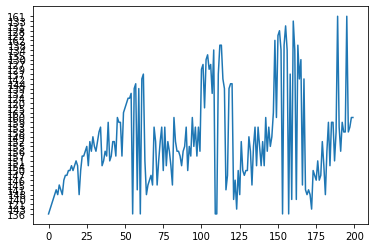

n_generations=50,
n_individuals=100,
n_survivors=30,
n_mutations=5,
n_crossovers=10


In [ ]:
output_list = output.split()
# 5-9 are the parameters
parameter=9
only = 0, 5
print(output_list[parameter::17][only[0]::only[1]])
plt.plot(output_list[16::17][only[0]::only[1]])
plt.show()
plt.plot(output_list[16::17])
plt.show()
min_iteration = np.argmin(output_list[16::17])
print(output_list[5::17][min_iteration])
print(output_list[6::17][min_iteration])
print(output_list[7::17][min_iteration])
print(output_list[8::17][min_iteration])
print(output_list[9::17][min_iteration])